In [415]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

import time
from tqdm import tqdm
import regex as re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [797]:
x = pd.read_csv("input.csv") 

In [798]:
len(x["patient_id"].unique())

2487

## Import and Train-Test-Val-Split

In [694]:
train_df = pd.read_csv("input_optimized.csv") 

train_df = train_df[['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']]
#train_df.columns = ['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']
train_df.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label
0,0,Z15564314,s other free text-see phs viewer social histor...,s other free text-see phs viewer Social Histor...,1
1,1,Z10171706,------- fusion: no sleep disturbance: no socia...,------- fusion: No Sleep disturbance: No Socia...,1
2,2,Z8935348,ain spasm). 30 tablet 0 unknown (outside pharm...,ain/spasm). 30 tablet 0 Unknown (outside pharm...,1
3,3,Z12212893,------- on 112mcg dose. maria will check dose ...,------- on 112mcg dose. Maria will check dos...,2
4,4,Z9598376,------- (vibramycin) 100 mg capsule take 1 cap...,------- (VIBRAMYCIN) 100 MG capsule Take 1 ca...,1


### 8050 - count of sequences with always pattern matches
### 606 - count of sequeunces w/o always pattern matches

### Train set - 8050 * 0.9 + 606 * 0.4 (7487)
### Validation Set - 8050 * 0.075 + 606 * .35 (816)
### Test Set - 8050 * 0.025 +  606 * .25 (353)

In [799]:
X = train_df[["patient_id", "sequence"]]
y = train_df["annotator_label"]
print(len(X))

y_label = y.to_numpy()
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X,y,random_state=0,test_size=0.1, stratify=y_label)

y_test_valid_label = y_test_valid.to_numpy()
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, random_state=0, test_size=0.25, stratify=y_test_valid_label)

8050


In [762]:
X = train_df["sequence"]
y = train_df["annotator_label"]
print(len(X))

y_label = y.to_numpy()
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X,y,random_state=0,test_size=0.1, stratify=y_label)

y_test_valid_label = y_test_valid.to_numpy()
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, random_state=0, test_size=0.25, stratify=y_test_valid_label)

8050


In [763]:
y_test.value_counts()

1    113
0     52
2     37
Name: annotator_label, dtype: int64

In [764]:
manual_review = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\test_and_validation.csv")

In [800]:
X_2 = manual_review[["patient_id","sequence"]]
y_2 = manual_review["annotator_label"]

y_label_2 = y_2.to_numpy()
X_train_2, X_test_valid_2, y_train_2, y_test_valid_2 = train_test_split(X_2,y_2,random_state=0,test_size=0.6, stratify=y_label_2)

y_test_valid_label_2 = y_test_valid_2.to_numpy()
X_valid_2, X_test_2, y_valid_2, y_test_2 = train_test_split(X_test_valid_2, y_test_valid_2, random_state=0, test_size=(0.25/0.6), stratify=y_test_valid_label_2)

In [801]:
X_train = X_train.append(X_train_2)
y_train = y_train.append(y_train_2)

In [802]:
X_test = X_test.append(X_test_2)
y_test = y_test.append(y_test_2)

X_valid = X_valid.append(X_valid_2)
y_valid = y_valid.append(y_valid_2)

In [804]:
len(X_train["patient_id"].unique())

2256

In [805]:
len(X_test["patient_id"].unique())+len(X_valid["patient_id"].unique())

946

### Having Solely Always pattern matches as part of train set and split 60% of manual-reviewed into validation and 40% into test (stratified across label)

In [622]:
X_train = train_df["sequence"]
y_train = train_df["annotator_label"]

In [690]:
# train_df[train_df["always_pattern_match"].str.len() == 0]

In [591]:
test_val_df = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\test_and_validation.csv")

In [595]:
X = test_val_df["sequence"]
y = test_val_df["annotator_label"]
y_label = y.to_numpy()

X_valid, X_test, y_valid, y_test = train_test_split(X,y,random_state=0,test_size=0.4, stratify=y_label)

## Additional Sampling to Obtain Optimal Data Sample

### Investigating why TFIDF vectors are combining words together

In [569]:
pattern = re.compile(r'attentionconcentration', re.IGNORECASE)

In [570]:
investigate = []
idxs = []
counter = 0
for seq in tqdm(train_df["sequence"]):
    m = pattern.search(seq)
    if (m != None):
        investigate.append(seq)
        idxs.append(counter)
        
#         specials = '-"/.~!' #etc
#         trans = seq.translate(str.maketrans(specials, ' '*len(specials)))
#         #print(trans)
#         train_df.loc[i]["sequence"] = trans
    counter += 1    

100%|██████████████████████████████████████████████████████████████████████████| 8656/8656 [00:00<00:00, 197791.93it/s]


In [573]:
idxs

[]

## Computing # of sequences that have always pattern matches to multiple classes

In [602]:
always_patterns = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\EDA\Data\always_patterns_8_1.csv")

In [603]:
always_pattern_regex = always_patterns["Pattern"].to_list()

In [604]:
for i in range(len(always_pattern_regex)):
    always_pattern_regex[i] = re.compile(always_pattern_regex[i], re.IGNORECASE)

In [605]:
a = []
c = []
counter = 0

for seq in tqdm(train_df["original"]):
    curr = []
    classes = []
    conversion = {2: "Yes", 1 : "Neither", 0: "No"}
    
    for p in (always_pattern_regex):
        m = list(set(re.findall(p, seq)))
        m = list(set(map(str.lower, m)))
        if (m != []):
            curr.append("".join(m))
            label = int(train_df.loc[counter]['annotator_label'])
            classes.append(conversion[label])
            #classes = list(set(classes))
            
    a.append(curr)
    c.append(classes)
    counter += 1

train_df["always_pattern_match"] = a
train_df["always_pattern_classes"] = c

100%|████████████████████████████████████████████████████████████████████████████| 8656/8656 [00:06<00:00, 1286.08it/s]


In [606]:
train_df.to_csv(r"input_with_always_and_without_8_1.csv", index = False)

In [580]:
train_df_optimal = train_df.drop(no_matches.index)

In [581]:
train_df_optimal["further_review"] = np.where((len(train_df_optimal["always_pattern_classes"]) > 1), 'N', 'Y')

In [582]:
further_review = train_df_optimal[train_df_optimal["further_review"] == 'Y']

In [583]:
further_review

,Unnamed: 0,patient_id,sequence,original,annotator_label,always_pattern_match,always_pattern_classes,further_review


In [585]:
train_df_optimal.to_csv(r"input_optimized.csv", index = False)

In [584]:
no_matches.to_csv(r"test_and_validation.csv", index = False)

### Computing Frequency per Keyword in dataset and comparing to overall 

In [429]:
regex = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\EDA\Getting_Data\keywords.csv")

In [430]:
k = regex["REGEX"].to_list()
c = regex["CASE"].to_list()
p_list = []

for i in range(len(k)):
    if (c[i] == 0):
        p_list.append(re.compile(k[i][5:], re.IGNORECASE))
    elif (c[i] == 1):
        p_list.append(re.compile(k[i]))
print(p_list)

[regex.Regex('\\bdementia\\b', flags=regex.I | regex.V0), regex.Regex('\\bcognition\\b', flags=regex.I | regex.V0), regex.Regex('\\bmemory\\b', flags=regex.I | regex.V0), regex.Regex('\\bMMSE\\b', flags=regex.I | regex.V0), regex.Regex('\\bMOCA\\b', flags=regex.I | regex.V0), regex.Regex('\\bAlzheimer\\b', flags=regex.I | regex.V0), regex.Regex('\\bcognitive\\s*impairment\\b', flags=regex.I | regex.V0), regex.Regex('(?-i:)\\bMCI\\b', flags=regex.V0), regex.Regex('\\bcerebellar\\b', flags=regex.I | regex.V0), regex.Regex('\\bNeurocognitive\\b', flags=regex.I | regex.V0), regex.Regex('\\blewy\\b', flags=regex.I | regex.V0), regex.Regex("\\bpick's\\b", flags=regex.I | regex.V0), regex.Regex('\\bCorticobasal\\b', flags=regex.I | regex.V0), regex.Regex('\\bcerebral\\b', flags=regex.I | regex.V0), regex.Regex('\\bcerebrovascular\\b', flags=regex.I | regex.V0), regex.Regex('\\bamnesia\\b', flags=regex.I | regex.V0), regex.Regex('(?-i:)\\bAD\\b', flags=regex.V0), regex.Regex('(?-i:)\\bLBD\\b',

In [433]:
l = []
for note in tqdm(train_df["original"]):
    curr = []
    for p in (p_list):
        m = list(set(re.findall(p, note)))
        m = list(set(map(str.lower, m)))
        if (m != []):
            curr.append("".join(m))
    #print(curr)
    #print(l)
    l.append(str(curr))
train_df["regex_match"] = l

100%|████████████████████████████████████████████████████████████████████████████| 8656/8656 [00:01<00:00, 5120.56it/s]


In [435]:
train_df.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label,regex_match
0,0,Z7593118,nown patientreported discontinued atenolol ten...,nown (patient-reported) • [DISCONTINUED] ateno...,1,['alzheimer']
1,1,Z7236549,patricia was asked if she didnt tell the staff...,Patricia was asked if she didn't tell the sta...,0,['memory']
2,2,Z6712628,ission note patient theodore buck mrn 04176434...,------- ission Note Patient: Theodore Buck MR...,1,['alzheimer']
3,3,Z12234642,extr warm and well perfused no evidence of ede...,"------- Extr: Warm and well perfused, no evi...",0,"['memory', 'cerebellar']"
4,4,Z7691325,e once a week enjoys travel goes to italy once...,"e once a week! Enjoys travel, goes to Italy on...",1,['alzheimer']


In [438]:
train_df.loc[i]['regex_match']

"['alzheimer']"

In [469]:
cols =  ['dementia', 'cognition',"\'cognition", 'memory', "memory\'", 'cdr', 'mmse', 'moca', 'alzheimer', 'cognitive impairment','cognitiveimpairment', 'mci', 'cerebellar', 'neurocognitive', 'lewy', "pick's", 'cortical', 'corticobasal', 'cerebral', 'cerebrovascular', 'amnesia', 'ad', 'lbd']
summary_stats  = pd.DataFrame(pd.np.empty((len(train_df), len(cols))) * pd.np.nan) 
summary_stats.columns = cols

In [466]:
for i in tqdm(range(len(train_df))):
    keyword_list = list(eval(train_df.loc[i]['regex_match']))
    #print(keyword_list, len(keyword_list))
    match_tuples = []
    for j in range(len(keyword_list)):
        x = keyword_list[j]

        match_tuples.append((x, 0))

    #print(match_tuples)

    freq = {"dementia":0
        ,"cognition":0
        ,"\'cognition":0
        ,"memory":0
        ,"memory\'":0
        ,"cdr":0
        ,"mmse":0
        ,"moca":0
        ,"alzheimer":0
        ,'cognitive impairment':0
        , "cognitiveimpairment":0
        ,"mci":0
        ,"cerebellar":0
        ,"neurocognitive":0
        ,"lewy":0
        ,"pick's":0
        ,"cortical":0
        ,"corticobasal":0
        ,"cerebral":0
        ,"cerebrovascular":0
        ,"amnesia":0
        ,'ad':0
        ,'lbd':0
    }

    for k, v in match_tuples:   
        if (k != ''):
            freq.update({str(k.lower()):int(freq[k.lower()] + 1)})

    #print(freq, "\n")

    #summary_stats["encounters_with_keywords"][i] = len(train_df[train_df["PatientID"] == unique_ids[i]])

    for k, v in freq.items():
        summary_stats[str(k.lower())][i] = int(v)

100%|█████████████████████████████████████████████████████████████████████████████| 8656/8656 [00:26<00:00, 329.07it/s]


In [467]:
summary_stats.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Optimizing-data\keywords_distribution_train_set_8_1.csv", index = False)

## Count-Vectorizer

In [768]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
count_valid = count_vectorizer.transform(X_valid)

# Create the CountVectorizer DataFrame: count_train
count_train = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_test = pd.DataFrame(count_test.A, columns=count_vectorizer.get_feature_names())
count_valid = pd.DataFrame(count_valid.A, columns=count_vectorizer.get_feature_names())

count_train.head()

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zupon,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF-Vectorizer

In [769]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english",analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')
tfidf_train= tfidf_vectorizer.fit_transform(X_train)
tfidf_valid = tfidf_vectorizer.transform(X_valid)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_valid = pd.DataFrame(tfidf_valid.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_test = pd.DataFrame(tfidf_test.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_valid.head()

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zupon,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparing Data for SMOTE

In [745]:
#ONLY run once
tfidf_train_features_df = pd.concat([tfidf_train, y_train.reset_index(drop=True)], axis=1)
tfidf_test_features_df = pd.concat([tfidf_test, y_test.reset_index(drop = True)], axis = 1)
tfidf_valid_features_df = pd.concat([tfidf_valid, y_valid.reset_index(drop = True)], axis = 1)

In [312]:
tfidf_train_features_df_data = tfidf_train_features_df.values
X_smote, y_smote = tfidf_train_features_df_data[:, :-1], tfidf_train_features_df_data[:, -1]

tfidf_test_features_df_data = tfidf_test_features_df.values
X_smote_test, y_smote_test = tfidf_test_features_df_data[:, :-1], tfidf_test_features_df_data[:, -1]

tfidf_valid_features_df_data = tfidf_valid_features_df.values
X_smote_valid, y_smote_valid = tfidf_valid_features_df_data[:, :-1], tfidf_valid_features_df_data[:, -1]

## SMOTE

In [313]:
oversample = SMOTE(k_neighbors = 1000)
X_train_new, y_train_new = oversample.fit_resample(X_smote, y_smote)

counter = Counter(y_train_new)
print("Train Data after SMOTE")
for k,v in counter.items():
    print('Class=%d, n=%d' % (k, v))

Train Data after SMOTE
Class=0, n=3793
Class=1, n=3793
Class=2, n=3793


In [314]:
oversample2 = SMOTE(k_neighbors = 150)
X_test_new, y_test_new = oversample2.fit_resample(X_smote_test, y_smote_test)
counter2 = Counter(y_test_new)
print("Test Data after SMOTE")
for k,v in counter2.items():
    print('Class=%d, n=%d' % (k, v))

Test Data after SMOTE
Class=1, n=469
Class=2, n=469
Class=0, n=469


In [315]:
oversample3 = SMOTE(k_neighbors = 130)
X_valid_new, y_valid_new = oversample3.fit_resample(X_smote_valid, y_smote_valid)
counter3 = Counter(y_valid_new)
print("Test Data after SMOTE")
for k,v in counter3.items():
    print('Class=%d, n=%d' % (k, v))

Test Data after SMOTE
Class=1, n=421
Class=2, n=421
Class=0, n=421


In [746]:
X_train_new = pd.DataFrame(X_train)
y_train_new = pd.Series(y_train)

X_test_new = pd.DataFrame(X_test)
y_test_new = pd.Series(y_test)

X_valid_new = pd.DataFrame(X_valid)
y_valid_new = pd.Series(y_valid)

In [640]:
x = list(tfidf_train_features_df.columns) 
x.append('annotator_label')
len(x)

24006

In [744]:
X_train_new

,sequence
3721,pleasant psychomotor: no abnormal movements st...
6945,unknown (outside pharmacy) • oseltamivir (tami...
3119,"------- 7), pulmonary emboli (2 27 2017), squa..."
7444,------- e reminded of their traumatic experien...
2411,ately mental functions: arousal: intact orient...
...,...
160,"vers. generally eats bread ham for breakfast, ..."
306,l source images were acquired. rotational mip ...
564,today past 24 hour overnight events: pt seen a...
393,use: no • drug use: no • sexual activity: yes ...


In [770]:
tfidf_train_features_df_new = tfidf_train_features_df #pd.concat([tfidf_train_features_df, y_train_new.reset_index(drop = True)], axis = 1)#pd.concat([X_train_new, y_train_new.reset_index(drop=True)], axis=1)
tmp = list(tfidf_train_features_df.columns) 
tfidf_train_features_df_new.columns = tmp

tfidf_test_features_df_new = tfidf_test_features_df #pd.concat([tfidf_test_features_df, y_test_new.reset_index(drop = True)], axis = 1)#pd.concat([X_test_new, y_test_new.reset_index(drop=True)], axis=1)
tmp2 = list(tfidf_test_features_df.columns) 
tfidf_test_features_df_new.columns = tmp2

tfidf_valid_features_df_new = tfidf_valid_features_df #pd.concat([tfidf_valid_features_df, y_valid_new.reset_index(drop = True)], axis = 1)#pd.concat([X_valid_new, y_valid_new.reset_index(drop=True)], axis=1)
tmp3 = list(tfidf_valid_features_df.columns) 
tfidf_valid_features_df_new.columns = tmp3

In [771]:
mappings = {0.0 : 0, 1.0 : 1, 2.0 : 2}

tfidf_train_features_df_new.annotator_label = [mappings[item] for item in tfidf_train_features_df_new.annotator_label]
tfidf_test_features_df_new.annotator_label = [mappings[item] for item in tfidf_test_features_df_new.annotator_label]
tfidf_valid_features_df_new.annotator_label = [mappings[item] for item in tfidf_valid_features_df_new.annotator_label]

tfidf_features_master = pd.concat([tfidf_train_features_df_new,tfidf_test_features_df_new,tfidf_valid_features_df_new])

tfidf_features_master.head()

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness,annotator_label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.052659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [772]:
tfidf_train_features_df_new.drop(columns = 'annotator_label')
tfidf_test_features_df_new.drop(columns = 'annotator_label')
tfidf_valid_features_df_new.drop(columns = 'annotator_label')

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zurek,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.032309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [773]:
tfidf_train_features_df_new

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness,annotator_label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.052659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
7604,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [751]:
full_tfidf = pd.concat([tfidf_train_features_df_new, tfidf_test_features_df_new, tfidf_valid_features_df_new])

## Filtering by Pearson Correlation Coefficient

In [774]:
def filter_features_by_cor(df):
    m = len(df.columns)
    output = df.iloc[:,m-1] 
    output_list = output.tolist()
    corrcoef_array = []

    for i in range(0,m-2):
        input_list = df.iloc[:,i].tolist()
        cols = [input_list, output_list]
        corrcoef = abs(np.corrcoef(cols)) 
        corrcoef_array = np.append(corrcoef_array,corrcoef[0,1])

    feature_names = list(df)
    feature_names = feature_names[0:m-2]
    
    output_df = pd.DataFrame(feature_names, columns=['Features'])
    output_df['CorrCoef'] = corrcoef_array
    output_df = output_df.sort_values('CorrCoef')
    output_df = output_df.reset_index()
    output_df = output_df.drop(columns = "index")
    
    return output_df

In [775]:
tfidf_output_df = filter_features_by_cor(tfidf_train_features_df)
tfidf_output_df = tfidf_output_df.sort_values(by=['CorrCoef'],ascending = False)

In [776]:
tfidf_output_df.head(10)

,Features,CorrCoef
23965,intact,0.562562
23964,oriented,0.426405
23963,concentration,0.420210
23962,orientation,0.405910
23961,perceptions,0.399497
23960,sensorium,0.399120
23959,judgment,0.388964
23958,fund,0.376844
23957,experiences,0.372629
23956,ideation,0.364612


In [777]:
tfidf_output_df.to_csv('Data/tfidf_vector_feature_corr_8_1.csv', index = False)

In [778]:
# Setting Correlation threshold
top_tfidf_features_df = tfidf_output_df[:500]
filtered_tfidf_train = tfidf_train_features_df_new.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_test = tfidf_test_features_df_new.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_valid   = tfidf_valid_features_df_new.filter(items=top_tfidf_features_df['Features'])
#filtered_tfidf_tanish = tfidf_tanish.filter(items = top_tfidf_features_df['Features'])

In [277]:
filtered_tfidf_train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\tfidf_train_smote.csv", index = False)
filtered_tfidf_test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\tfidf_test_smote.csv", index = False)
filtered_tfidf_valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\tfidf_validation_smote.csv", index = False)

In [278]:
y_train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\y_train_smote.csv", index = False)
y_test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\y_test_smote.csv", index = False)
y_valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\y_validation_smote.csv", index = False)

## Finding Optimal Correlation Threshold Value by running Logistic Regression model on Validation Set

In [780]:
def filter_by_corr(corr, tfidf_output_df):
    # Setting Correlation threshold
    top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
    filtered_tfidf_train = tfidf_train_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_valid = tfidf_valid_features_df.filter(items=top_tfidf_features_df['Features'])
    
    return top_tfidf_features_df, filtered_tfidf_train, filtered_tfidf_test, filtered_tfidf_valid

In [789]:
def logisitic_regression(X_train, y_train, X_test, y_test, c, want_report, want_conf_mat):
    # fitting model
    lr = LogisticRegression(penalty='l1', solver='liblinear', C = c, random_state=0)
    lr.fit(X_train, y_train)

    # predictions
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)

    # collecting results
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovr')
    
    if (want_report == True):
        target_names = ['NO', 'NTR', 'YES']
        results_lgr = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
        results_lgr = pd.DataFrame(results_lgr).transpose()
        
        if (want_conf_mat == True):
            return lr, acc, auc, c, results_lgr, confusion_matrix(y_test, y_pred)
    
        return lr, acc, auc, c, results_lgr
    
    if (want_conf_mat == True):
        return lr, acc, auc, c, confusion_matrix(y_test, y_pred)
        
    return lr, acc, auc, c

In [790]:
corr_list = list(np.arange(1,30) * 0.01)
df_list  = []

for corr in corr_list:
    acc_list = []
    auc_list = []
    c_list   = []
    
    top_tfidf_features_df, filtered_tfidf_train, filtered_tfidf_test, filtered_tfidf_valid = filter_by_corr(corr, tfidf_output_df)
    
    for c in [0.01, 0.1, 1, 10, 100]:
        lr, acc, auc, c = logisitic_regression(filtered_tfidf_train, y_train_new, filtered_tfidf_valid, y_valid_new, c, False, False)
        acc_list.append(acc)
        auc_list.append(auc)
        c_list.append(c)

    acc_df = pd.DataFrame(acc_list, columns=['acc'])
    auc_df = pd.DataFrame(auc_list, columns=['auc'])
    c_df = pd.DataFrame(c_list, columns=['c_value'])
    iter_df = pd.concat([c_df, acc_df, auc_df], axis=1)
    iter_df['corr_thres'] = corr
    df_list.append(iter_df)
    
tfidf_all_df = pd.concat(df_list, axis = 0)

In [783]:
tfidf_all_df = tfidf_all_df.reset_index(drop = True)

In [779]:
tfidf_all_df.to_csv('tfidf_vect_performance_l1_regularization_v2_8_1_take_2.csv')

In [791]:
tfidf_all_df.head()

,c_value,acc,auc,corr_thres
0,0.01,0.591512,0.870590,0.01
1,0.10,0.814324,0.942851,0.01
2,1.00,0.866048,0.966272,0.01
3,10.00,0.875332,0.967933,0.01
4,100.00,0.866048,0.965148,0.01


In [792]:
tfidf_all_df[tfidf_all_df['auc'] == max(tfidf_all_df['auc'])]

,c_value,acc,auc,corr_thres
3,10.0,0.863395,0.968782,0.03


In [793]:
tfidf_all_df[tfidf_all_df['auc'] == min(tfidf_all_df['auc'])]

,c_value,acc,auc,corr_thres
0,0.01,0.584881,0.715626,0.13
0,0.01,0.584881,0.715626,0.14
0,0.01,0.584881,0.715626,0.15
0,0.01,0.584881,0.715626,0.16
0,0.01,0.584881,0.715626,0.17
0,0.01,0.584881,0.715626,0.18
0,0.01,0.584881,0.715626,0.19
0,0.01,0.584881,0.715626,0.20
0,0.01,0.584881,0.715626,0.21
0,0.01,0.584881,0.715626,0.22


In [667]:
len(tfidf_all_df[tfidf_all_df['auc'] > 0.95])

0

## Running Logistic Regression model with Optimal Parameters (identified from validation set) on Test Set

In [794]:
# Specific parameter setting performance
corr = 0.03
c = 10

# Setting Correlation threshold
top_tfidf_features_df, filtered_tfidf_train, filtered_tfidf_test, filtered_tfidf_valid = filter_by_corr(corr, tfidf_output_df)

# training model
lr, acc_optimized, auc_optimized, c_list, report, conf_mat = logisitic_regression(filtered_tfidf_train, y_train_new, filtered_tfidf_test, y_test_new, c, True, True)

print("\nC: ", c, "\n", report)
print("\nAUC: ", auc_optimized)
print("ACC: ", acc_optimized)
print("\nConfusion Matrix: \n", conf_mat)


C:  10 
               precision    recall  f1-score     support
NO             0.830000  0.790476  0.809756  105.000000
NTR            0.909091  0.851064  0.879121  141.000000
YES            0.580645  0.750000  0.654545   48.000000
accuracy       0.812925  0.812925  0.812925    0.812925
macro avg      0.773245  0.797180  0.781141  294.000000
weighted avg   0.827220  0.812925  0.817682  294.000000

AUC:  0.9406550851079881
ACC:  0.8129251700680272

Confusion Matrix: 
 [[ 83   7  15]
 [ 10 120  11]
 [  7   5  36]]


In [811]:
FP = conf_mat.sum(axis=0) - np.diag(conf_mat) 
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)

Sensitivity:  [0.79047619 0.85106383 0.75      ]
Specificity:  [0.91005291 0.92156863 0.89430894]
NPV:  [0.88659794 0.87037037 0.94827586]
PPV:  [0.83       0.90909091 0.58064516]


In [ ]:
"""   
      NO   NTR YES
NO  [[439  9  21]
NTR [  5 457   7]
YES [ 26  19 424]]

NO - 439/469 TP, 9/469 NTR when should be NO, and 21/469 YES when should be NO
    Precision: 439/(439+5+26)
    Recall: 439/(439+21+9)
    fl: (439*2)/(470+469)

NTR - 457/469 TP, 5/469 NO when should be NTR, and 7/469 YES when should be NTR
YES - 424/469 TP, 19/469 NTR when should be YES, and 26/469 are NO when should be YES
"""

In [ ]:
"""
ROC-AUC:
    TPR = TP / P = TP / (TP+FN) = number of true positives / number of positives
    FPR = FP / N = FP / (FP+TN) = number of false positives / number of negatives
    plots FPR aganist TPR 
    
classifier achieves the good performance on the positive class (high AUC) 
at the cost of a high false negatives rate (or a low number of true negative), resulting in low ACC.
"""

<BarContainer object of 20 artists>

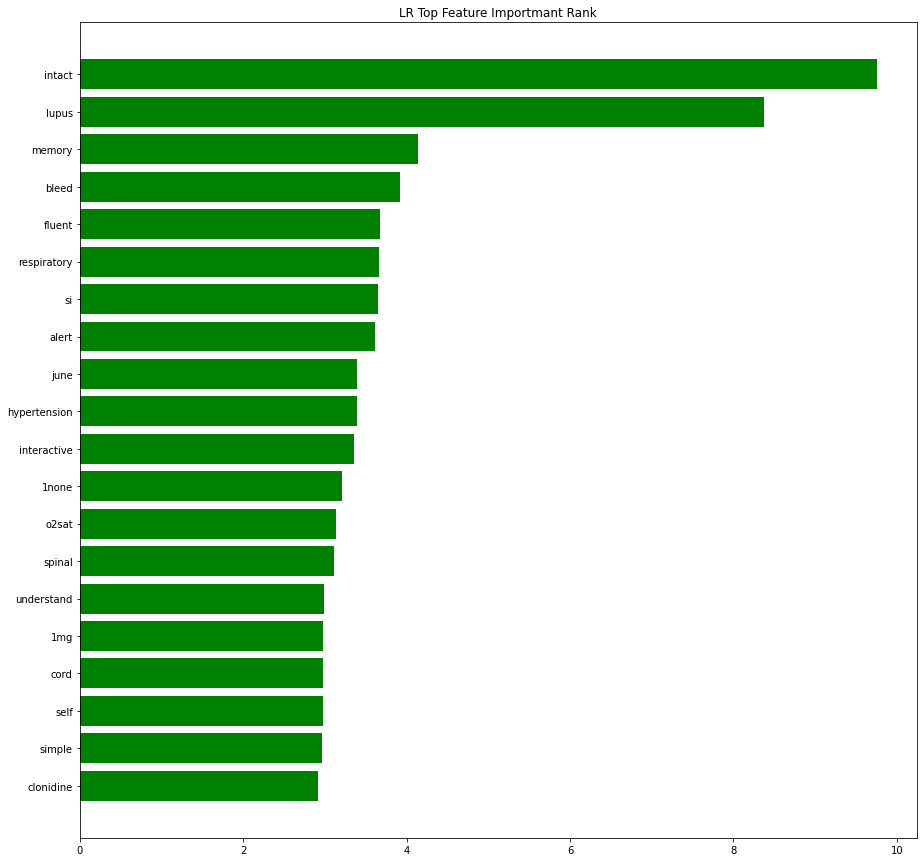

In [370]:
show_number = 20
lr_feature_names = list(filtered_tfidf_train.columns)
lr_feature_coef = list(lr.coef_.tolist()[0])
lr_feature_importance_df = pd.DataFrame(list(zip(lr_feature_names,lr_feature_coef)), columns = ['feature','lr_coef'])
lr_feature_importance_df = lr_feature_importance_df.sort_values('lr_coef',ascending=False)

plt.figure(figsize=(15,15))
plt.title("LR Top Feature Importmant Rank")
plt.gca().invert_yaxis()
plt.barh(lr_feature_importance_df[:show_number]['feature'], lr_feature_importance_df[:show_number]['lr_coef'], color='g')